In [1]:
import torch 
from torch.utils import data # 获取迭代数据
from torch.autograd import Variable # 获取变量
import torchvision
from torchvision.datasets import mnist # 获取数据集
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from pytorchtools import EarlyStopping
scaler = MinMaxScaler(feature_range=(0, 1))

In [2]:
# # 数据集的预处理
# data_tf = torchvision.transforms.Compose(
#     [
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize([0.5],[0.5])
#     ]
# )

# data_path = r'C:\Users\16526\Desktop\dataset'
# # 获取数据集
# train_data = mnist.MNIST(data_path,train=True,transform=data_tf,download=False)
# test_data = mnist.MNIST(data_path,train=False,transform=data_tf,download=False)

In [3]:
all_data = pd.read_csv(r"C:\Code\Python\PycharmProjects\数据分析\数据分析\shuffle.csv",index_col=0)
va = int(len(all_data)*0.7)
train_data = all_data[0:va]
test_data = all_data[va:]

In [4]:
max_value = max(train_data.max().values)
min_value = min(train_data.min().values)
ch = max_value - min_value

In [5]:
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
train_data_normalized = train_data_normalized.reshape(-1,337)
train_data_normalized.shape

(1309, 337)

In [6]:
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))
test_data_normalized = test_data_normalized.reshape(-1,337)
test_data_normalized.shape

(562, 337)

In [7]:
train_X = torch.Tensor(train_data_normalized[:,0:-1].reshape(-1,1, 14, 24))
train_Y = torch.Tensor(train_data_normalized[:,-1].reshape(-1))
train_Y.shape

torch.Size([1309])

In [8]:
test_X = torch.Tensor(test_data_normalized[:,0:-1].reshape(-1,1, 14, 24))
test_Y = torch.Tensor(test_data_normalized[:,-1].reshape(-1))
test_X.shape

torch.Size([562, 1, 14, 24])

In [9]:
train_data_temp = torch.utils.data.TensorDataset(train_X, train_Y)
test_data_temp = torch.utils.data.TensorDataset(test_X, test_Y)

In [10]:
train_loader = data.DataLoader(train_data_temp,batch_size=128,shuffle=False)
test_loader = data.DataLoader(test_data_temp,batch_size=100,shuffle=False)

In [11]:
# 定义网络结构
class CNNnet(torch.nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,
                            out_channels=16,
                            kernel_size=3,
                            stride=2,
                            padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,3,2,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU()
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,3,2,1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
#         self.conv4 = torch.nn.Sequential(
#             torch.nn.Conv2d(64,64,2,2,0),
#             torch.nn.BatchNorm2d(64),
#             torch.nn.ReLU()
#         )
        self.lstm = nn.LSTM(24,128,1,batch_first=True)
        self.mlp1 = torch.nn.Linear(128*16,1)
#         self.mlp2 = torch.nn.Linear(128,1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
#         x = self.conv4(x)
        x = x.reshape(-1,16,24)
        x,_ = self.lstm(x)
#         x = x[:,[13],:]
        x = self.mlp1(x.reshape(x.size(0),-1))
#         x = self.mlp2(x)
        return x
model = CNNnet()
print(model)

CNNnet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (lstm): LSTM(24, 128, batch_first=True)
  (mlp1): Linear(in_features=2048, out_features=1, bias=True)
)


In [12]:
loss_func = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr=0.01)

0:	 0.0957665890455246


D:\Softwore\python38\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type CNNnet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
D:\Softwore\python38\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0:	 0.06580646336078644
0:	 0.030491743236780167
0:	 0.02949545904994011
0:	 0.02760443463921547
0:	 0.02774765156209469
0:	 0.02804175764322281
0:	 0.027806803584098816
0:	 0.027467921376228333
0:	 0.027214491739869118
0:	 0.0270727276802063
0:	 0.027031736448407173
0:	 0.027065321803092957
0:	 0.027158426120877266
0:	 0.02729133889079094
0:	 0.027437053620815277
0:	 0.02757210284471512
0:	 0.02768508903682232
0:	 0.027777280658483505
0:	 0.027854545041918755
0:	 0.027922652661800385
0:	 0.027984313666820526
0:	 0.02803964540362358
0:	 0.028087925165891647
0:	 0.02813001722097397
0:	 0.028167203068733215
0:	 0.02820071205496788
0:	 0.028230959549546242
0:	 0.028257906436920166
0:	 0.028282616287469864
0:	 0.028304360806941986
0:	 0.028323540464043617
0:	 0.02834079973399639
0:	 0.028356263414025307
0:	 0.02836953103542328
0:	 0.028380971401929855
0:	 0.02839066833257675
0:	 0.02839917317032814
0:	 0.028406284749507904
0:	 0.028411809355020523
0:	 0.028416121378540993
0:	 0.02841896936

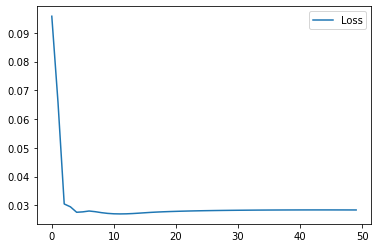

In [13]:
loss_count = []
for epoch in range(50):
    for i,(x,y) in enumerate(train_loader):
        batch_x = Variable(x) # torch.Size([128, 1, 14, 24])
        batch_y = Variable(y)# torch.Size([128])
        # 获取最后输出
        out = model(batch_x) # torch.Size([128,10])
        # 获取损失
        loss = loss_func(out,batch_y)
        # 使用优化器优化损失
        opt.zero_grad()  # 清空上一步残余更新参数值
        loss.backward() # 误差反向传播，计算参数更新值
        opt.step() # 将参数更新值施加到net的parmeters上
        if i%20 == 0:
            loss_count.append(loss)
            print('{}:\t'.format(i), loss.item())
            torch.save(model,r'C:\Users\16526\Desktop\dataset\log_CNN')
plt.figure('PyTorch_CNN_Loss')
plt.plot(loss_count,label='Loss')
plt.legend()
plt.show()

In [14]:
torch.save(model,'log_CNN.pkl')
model2 = torch.load('log_CNN.pkl')

In [15]:
def rereal(list_temp, min_value, max_value):
    arr = []
    for dat in list_temp:
        temp = dat*(max_value-min_value) + min_value
        arr.append(temp)
    return arr

In [16]:
outputs = model2(test_X)
loss = loss_func(outputs, test_Y)
loss

D:\Softwore\python38\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([562])) that is different to the input size (torch.Size([562, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0215, grad_fn=<MseLossBackward>)

In [17]:
num = len(test_Y)

In [18]:
outputs = outputs.reshape(num)
y_pred_temp = outputs.detach().numpy()
tru_temp = test_Y.detach().numpy().reshape(num)

In [19]:
MSE = 0
for i in range(num):
    MSE += (y_pred_temp[i] - tru_temp[i])**2
MSE /= num
MSE

0.021384842751074534

In [20]:
predict = rereal(y_pred_temp,min_value,max_value)
truth =  rereal(tru_temp,min_value,max_value)

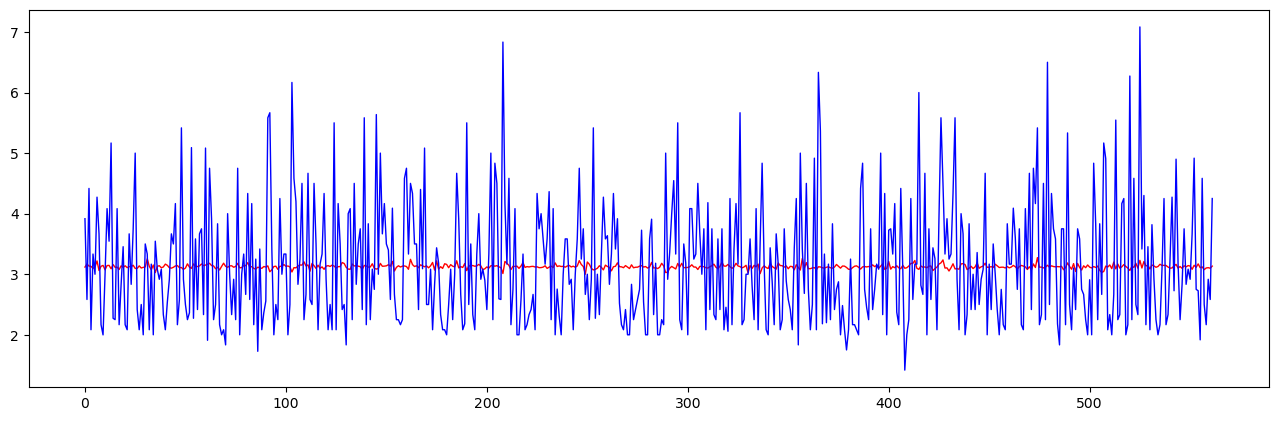

In [21]:
# 还原归一化
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), predict, c='red', lw='1')
plt.plot(range(num), truth, c='blue', lw='1')

In [22]:
# 求真实值与预测值的MSE
MSE = 0
for i in range(num):
    MSE += (predict[i] - truth[i])**2
MSE /= num
MSE

1.0230371035322432

(0.0, 3.0)

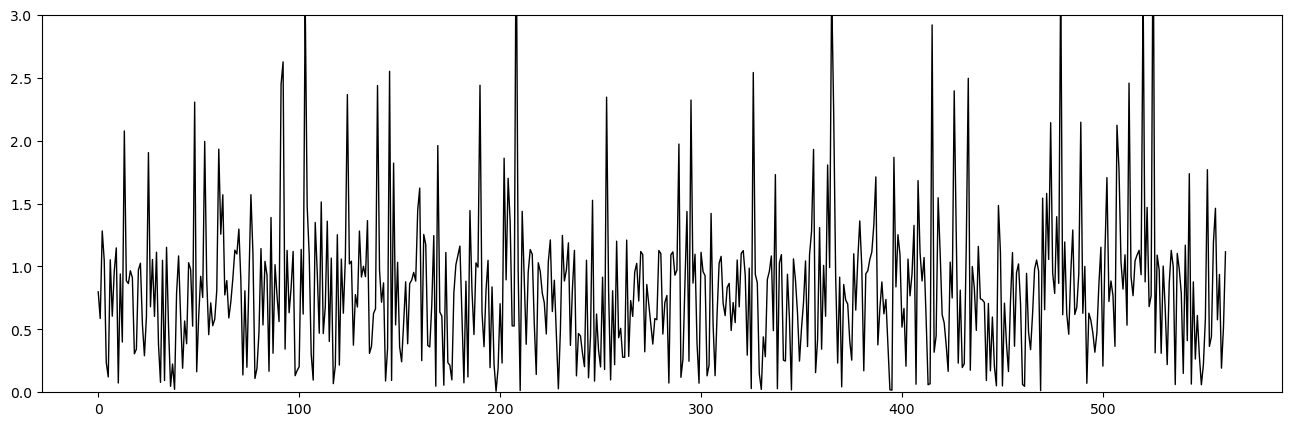

In [23]:
# 求真实值与预测值的误差值
errors = []
for i in range(num):
    error = abs(truth[i] - predict[i])
    errors.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors, c='black', lw='1')
plt.ylim(0,3)

(0.0, 70.0)

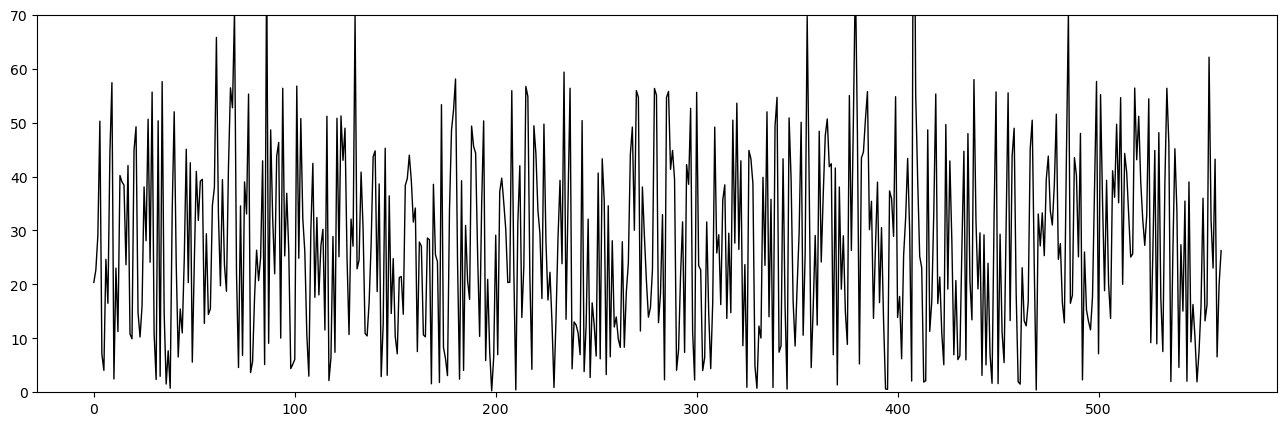

In [24]:
# 求真实值与预测值的误差值占原真实值的百分比
errors_p = []
for i in range(num):
    error = ((abs(truth[i] - predict[i]))/truth[i])*100
    errors_p.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors_p, c='black', lw='1')
plt.ylim(0,70)

In [25]:
from numpy import mean
mean(errors_p)

27.39053188125574